## INTRODUCTION
Companies use churn analysis to understand customer behavior, predict and identify customers who are likely to leave (churn), and develop targeted retention strategies. The ability to predict and mitigate customer churn can have a substantial impact on a company's bottom line.

This repository presents a comprehensive churn analysis, leveraging the power of PySpark, a robust and scalable data processing framework. Our primary objective is twofold:

**1. Identify and Visualize Contributing Factors:** Through in-depth exploration, we aim to uncover the factors that significantly influence customer churn. 

**2. Build and Deploy Predictive Models:** Our focus is on developing predictive models that can classify whether a customer is likely to churn or not. But we're taking it a step further. Leveraging PySpark's distributed computing capabilities, we ensure that our models are not only accurate but also capable of handling massive datasets that are common in today's business landscape.

In [781]:
# spark imports
from pyspark import SparkContext
import pyspark
from pyspark.sql import SparkSession
from pyspark.conf import SparkConf
from pyspark.sql import functions as F
from pyspark.ml.feature import StringIndexer, OneHotEncoder,  VectorAssembler

# model
from pyspark.ml.classification import RandomForestClassifier, GBTClassifier, LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml import Pipeline

import pandas as pd

# visualization
import matplotlib.pyplot as plt
import seaborn as sns

In [782]:
# # Initialize Spark session
spark = SparkSession.builder.master('local').appName('ChurnAnalysis').getOrCreate()

In [783]:
sc = spark.sparkContext

In [784]:
sc

<SparkContext master=local appName=ChurnAnalysis>

You can access the Spark Web UI by clicking the "Spark UI" link above.

### 1. DATA EXPLORATION

#### 1.1 Data Loading

In [785]:
spark_df = spark.read.csv('./Bank_Customer_Churn_Prediction.csv', header = True, inferSchema = True)  # inferSchema: to show schema

#### 1.2 Exploring Dataset

In [786]:
# to show features of dataset
spark_df.printSchema()

root
 |-- customer_id: integer (nullable = true)
 |-- credit_score: integer (nullable = true)
 |-- country: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- age: integer (nullable = true)
 |-- tenure: integer (nullable = true)
 |-- balance: double (nullable = true)
 |-- products_number: integer (nullable = true)
 |-- credit_card: integer (nullable = true)
 |-- active_member: integer (nullable = true)
 |-- estimated_salary: double (nullable = true)
 |-- churn: integer (nullable = true)



In [787]:
# to show first 5 rows in the dataset
spark_df.show(5, truncate=True)

+-----------+------------+-------+------+---+------+---------+---------------+-----------+-------------+----------------+-----+
|customer_id|credit_score|country|gender|age|tenure|  balance|products_number|credit_card|active_member|estimated_salary|churn|
+-----------+------------+-------+------+---+------+---------+---------------+-----------+-------------+----------------+-----+
|   15634602|         619| France|Female| 42|     2|      0.0|              1|          1|            1|       101348.88|    1|
|   15647311|         608|  Spain|Female| 41|     1| 83807.86|              1|          0|            1|       112542.58|    0|
|   15619304|         502| France|Female| 42|     8| 159660.8|              3|          1|            0|       113931.57|    1|
|   15701354|         699| France|Female| 39|     1|      0.0|              2|          0|            0|        93826.63|    0|
|   15737888|         850|  Spain|Female| 43|     2|125510.82|              1|          1|            1|

In [788]:
# To get the total number of rows in the spark_df
spark_df.count()

10000

In [789]:
# Compute basic statistics for numerical columns in the DataFrame
# and display the result in tabular format
spark_df.describe().show()

+-------+-----------------+-----------------+-------+------+------------------+------------------+-----------------+------------------+-------------------+-------------------+-----------------+-------------------+
|summary|      customer_id|     credit_score|country|gender|               age|            tenure|          balance|   products_number|        credit_card|      active_member| estimated_salary|              churn|
+-------+-----------------+-----------------+-------+------+------------------+------------------+-----------------+------------------+-------------------+-------------------+-----------------+-------------------+
|  count|            10000|            10000|  10000| 10000|             10000|             10000|            10000|             10000|              10000|              10000|            10000|              10000|
|   mean|  1.56909405694E7|         650.5288|   null|  null|           38.9218|            5.0128|76485.88928799961|            1.5302|         

In [790]:
spark_df.describe('Age').show()

+-------+------------------+
|summary|               Age|
+-------+------------------+
|  count|             10000|
|   mean|           38.9218|
| stddev|10.487806451704587|
|    min|                18|
|    max|                92|
+-------+------------------+



In [791]:
spark_df.groupby('Churn').count().show()

+-----+-----+
|Churn|count|
+-----+-----+
|    1| 2037|
|    0| 7963|
+-----+-----+



In [792]:
spark_df.groupby('Churn', 'active_member').count().show()

+-----+-------------+-----+
|Churn|active_member|count|
+-----+-------------+-----+
|    1|            0| 1302|
|    1|            1|  735|
|    0|            0| 3547|
|    0|            1| 4416|
+-----+-------------+-----+



In [793]:
spark_df.groupby('Churn', 'gender').count().show()

+-----+------+-----+
|Churn|gender|count|
+-----+------+-----+
|    1|Female| 1139|
|    0|  Male| 4559|
|    1|  Male|  898|
|    0|Female| 3404|
+-----+------+-----+



**NOTE:** It shows that there are more non-churned customers (Churn = 0) than churned customers (Churn = 1) for both genders.
There are more male customers in both the churned and non-churned categories compared to female customers.

In [794]:
spark_df.groupby('Churn', 'gender').agg({'Age':'mean'}).show()

+-----+------+-----------------+
|Churn|gender|         avg(Age)|
+-----+------+-----------------+
|    1|Female|44.78489903424056|
|    0|  Male|37.42772537837245|
|    1|  Male|44.90534521158129|
|    0|Female|37.38249118683901|
+-----+------+-----------------+



**Note:** It appears that, on average, churned customers (Churn = 1) tend to be slightly older than non-churned customers (Churn = 0), 
regardless of gender.

In [795]:
spark_df.groupby('Churn', 'gender').agg({'tenure':'mean', 'balance':'mean', 'estimated_salary':'mean'}).show()

+-----+------+-----------------+---------------------+-----------------+
|Churn|gender|     avg(balance)|avg(estimated_salary)|      avg(tenure)|
+-----+------+-----------------+---------------------+-----------------+
|    1|Female|89036.63935908697|   102948.98609306425|4.933274802458297|
|    0|  Male| 73911.6070366309|    99680.39182715533|5.075235797323974|
|    1|  Male|93736.48374164799|    99584.28727171487|4.932071269487751|
|    0|Female|71183.24963866033|    99816.07148648654|4.977085781433607|
+-----+------+-----------------+---------------------+-----------------+



In [796]:
result_df = spark_df.groupBy('Churn', 'gender', 'active_member').count().orderBy('gender').show()

+-----+------+-------------+-----+
|Churn|gender|active_member|count|
+-----+------+-------------+-----+
|    1|Female|            1|  414|
|    1|Female|            0|  725|
|    0|Female|            0| 1534|
|    0|Female|            1| 1870|
|    0|  Male|            0| 2013|
|    1|  Male|            0|  577|
|    0|  Male|            1| 2546|
|    1|  Male|            1|  321|
+-----+------+-------------+-----+



In [797]:
result_df = spark_df.groupBy('Churn', 'credit_card', 'active_member').count().show()

+-----+-----------+-------------+-----+
|Churn|credit_card|active_member|count|
+-----+-----------+-------------+-----+
|    0|          1|            1| 3125|
|    0|          0|            0| 1041|
|    1|          0|            1|  253|
|    1|          1|            1|  482|
|    1|          0|            0|  360|
|    1|          1|            0|  942|
|    0|          1|            0| 2506|
|    0|          0|            1| 1291|
+-----+-----------+-------------+-----+



In [798]:
spark_df.select('age', 'tenure', 'balance', 'products_number', 'credit_card', 'active_member', 'estimated_salary', 'churn').describe().toPandas().transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
age,10000,38.9218,10.487806451704587,18,92
tenure,10000,5.0128,2.8921743770496837,0,10
balance,10000,76485.88928799961,62397.40520238599,0.0,250898.09
products_number,10000,1.5302,0.5816543579989917,1,4
credit_card,10000,0.7055,0.45584046447513327,0,1
active_member,10000,0.5151,0.49979692845891815,0,1
estimated_salary,10000,100090.2398809998,57510.49281769821,11.58,199992.48
churn,10000,0.2037,0.40276858399486065,0,1


#### 1.3. Data Visualization

**NOTE:** To perform visualization in PySpark, you typically need to convert your data to a Pandas DataFrame and then utilize Pandas' data visualization libraries.If you have large datasets, it may be helpful to reduce or sample data before visualization.

In [799]:
df = spark_df.toPandas()

In [800]:
# let's take a look to pandas dataframe
df.head()

,customer_id,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn
0,15634602,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,15647311,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,15619304,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,15701354,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,15737888,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


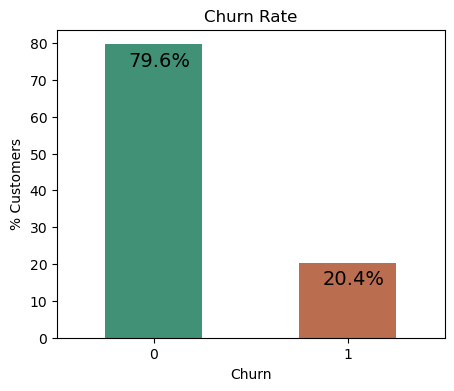

In [801]:
colors = ['#419177','#BB6D4F']  
ax = (df['churn'].value_counts()*100.0 /len(df)).plot(kind='bar',
                                                      rot = 0,
                                                      color = colors,
                                                      figsize = (5,4))
ax.set_ylabel('% Customers')
ax.set_xlabel('Churn')
ax.set_title('Churn Rate')

for i in ax.patches:
    # get_width pulls left or right, get_y pushes up or down
    ax.text(i.get_x()+.12, i.get_height()-6.0, \
            str(round((i.get_height()/total), 1))+'%',
            color='black',
            size = 14)

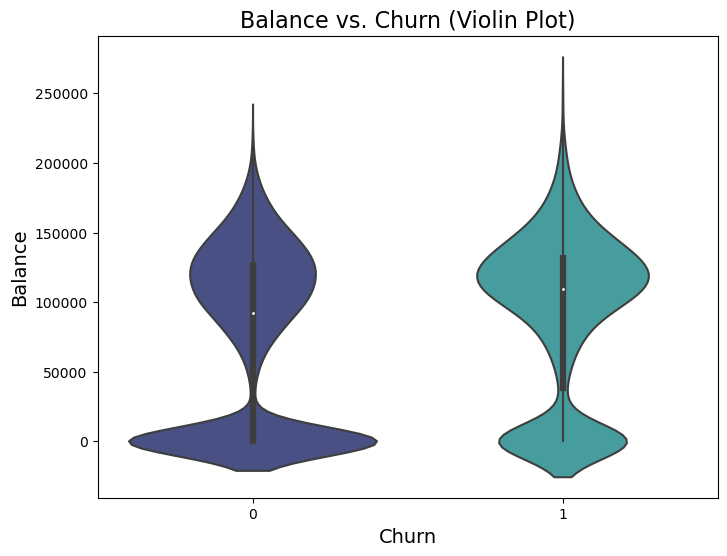

In [802]:
# Violin Plot
plt.figure(figsize=(8, 6))
sns.violinplot(data=df, x='churn', y='balance', palette='mako')
plt.xlabel('Churn', fontsize=14)
plt.ylabel('Balance', fontsize=14)
plt.title('Balance vs. Churn (Violin Plot)', fontsize=16)
plt.show()

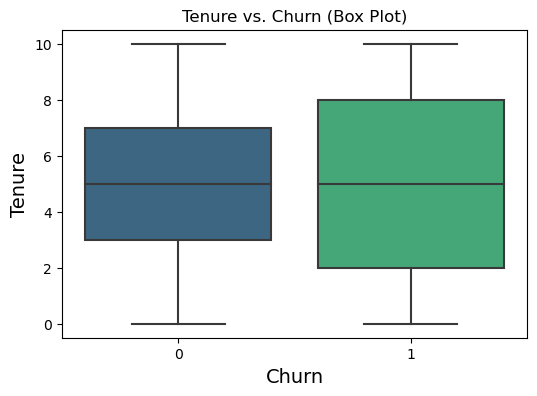

In [803]:
# Box Plot
plt.figure(figsize=(6, 4))
sns.boxplot(data=df, x='churn', y='tenure', palette='viridis')
plt.xlabel('Churn', fontsize=14)
plt.ylabel('Tenure', fontsize=14)
plt.title('Tenure vs. Churn (Box Plot)', fontsize=12)
plt.show()

<Axes: xlabel='active_member', ylabel='count'>

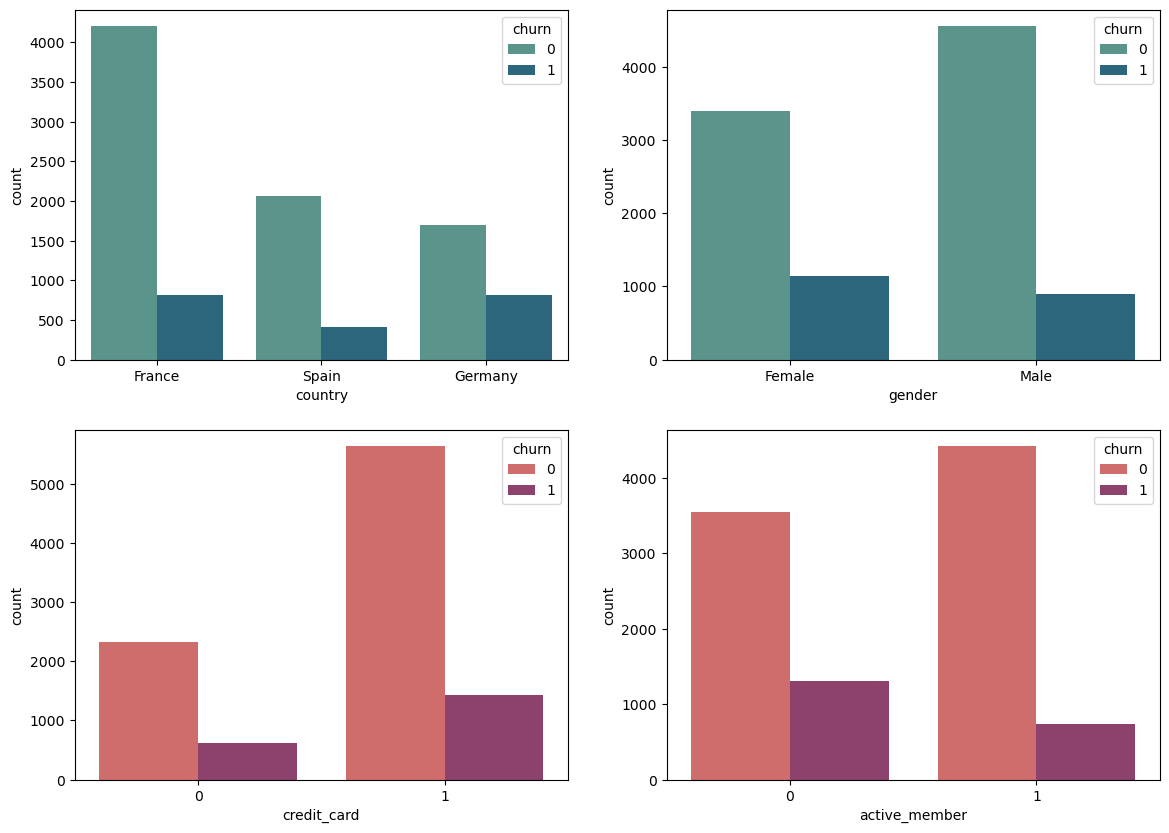

In [804]:
fig, axarr = plt.subplots(2, 2, figsize=(14, 10))
sns.countplot(x='country', hue='churn', data=df, ax=axarr[0][0], palette="crest")
sns.countplot(x='gender', hue='churn', data=df, ax=axarr[0][1], palette="crest")
sns.countplot(x='credit_card', hue='churn', data=df, ax=axarr[1][0], palette="flare")
sns.countplot(x='active_member', hue='churn', data=df, ax=axarr[1][1], palette="flare")

C:\Users\Miray\AppData\Local\Temp\ipykernel_12664\1453951042.py:1: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.catplot(x = 'churn', y = 'balance', data = df, palette='mako');


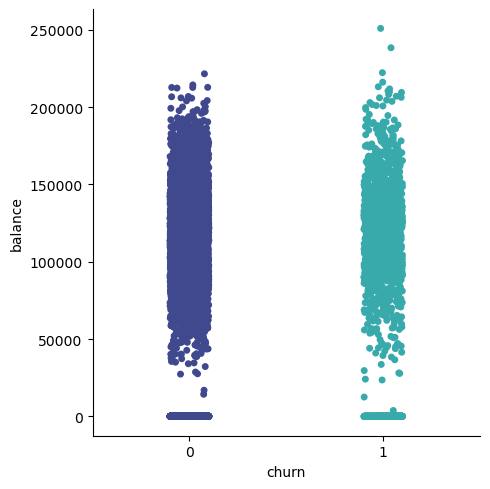

In [805]:
sns.catplot(x = 'churn', y = 'balance', data = df, palette='mako');

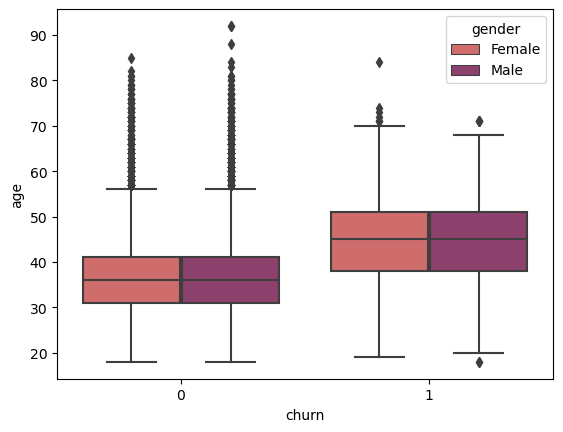

In [806]:
sns.boxplot(x = 'churn', y = 'age', hue = 'gender', data = df, palette='flare');

C:\Users\Miray\AppData\Local\Temp\ipykernel_12664\445480407.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = df.corr()


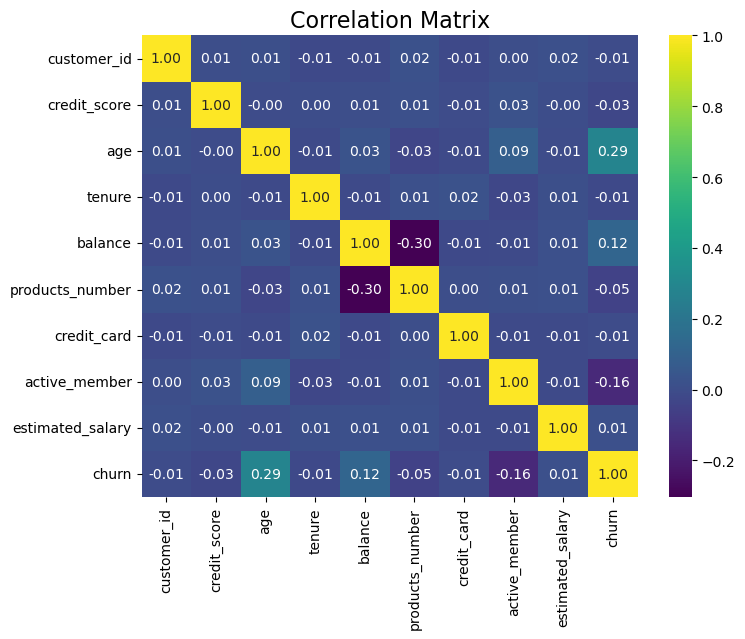

In [807]:
correlation_matrix = df.corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='viridis', fmt=".2f")
plt.title("Correlation Matrix", fontsize=16)
plt.show()

### INSIGHTS
**Customer Engagement Strategy:** The analysis indicates that active members tend to have a lower likelihood of churning. However, it's noteworthy that only around half of our customers are active members. To mitigate churn risk, it's essential to focus on not only retaining our existing active members but also on converting a larger portion of our customer base into active members. This dual approach can help in strengthening customer loyalty and reducing churn.

**Balance Impact:** There appears to be no significant correlation between the balance and churn rate. While balance alone might not be a strong predictor of churn, it's crucial to consider it in conjunction with other relevant features to uncover more subtle churn patterns.

**Gender-Based Insights:** The analysis suggests that female customers exhibit a higher churn risk compared to males. This observation opens up an opportunity for the bank to develop targeted strategies aimed at reducing churn among female customers. Tailored initiatives and services that address the specific needs and concerns of female customers could potentially lead to a decrease in the gender-specific churn rate.

**Geographical Focus:** German customers appear to have a relatively higher churn rate. To address this trend, it's recommended to prioritize region-specific campaigns and initiatives within the German market. Targeted engagement efforts can be employed to understand the unique factors contributing to churn among German customers and tailor strategies that resonate with their preferences and expectations.

**Age Considerations:** An interesting trend emerges regarding age. As age increases, there seems to be a slight upward trend in churn propensity. To address this, targeted outreach and services can be designed to cater to the needs and expectations of customers in higher age groups.

**Feature Importance:** The analysis reveals that none of the features exhibit strong collinearity or correlation with each other. I'll keep all features in the model. Continuously monitoring and refining the model's performance, considering all available features, is crucial to capturing diverse churn indicators.

By implementing these insights, the bank can create a more comprehensive churn prevention strategy that encompasses customer engagement, gender-based initiatives, geographical targeting, age-specific approaches, and the utilization of a well-rounded set of features to enhance the accuracy of churn prediction. This approach can lead to better customer retention rates, improved business performance, and enhanced customer satisfaction.


### 2. DATA PRE-PROCESSING

In [808]:
# to count missing value in each feature
null_counts = spark_df.select(*[F.sum(F.when(F.col(col).isNull(), 1).otherwise(0)).alias(col) for col in spark_df.columns])
null_counts.show()

+-----------+------------+-------+------+---+------+-------+---------------+-----------+-------------+----------------+-----+
|customer_id|credit_score|country|gender|age|tenure|balance|products_number|credit_card|active_member|estimated_salary|churn|
+-----------+------------+-------+------+---+------+-------+---------------+-----------+-------------+----------------+-----+
|          0|           0|      0|     0|  0|     0|      0|              0|          0|            0|               0|    0|
+-----------+------------+-------+------+---+------+-------+---------------+-----------+-------------+----------------+-----+



In [809]:
# Select categorical columns for one-hot-encoding
categorical_cols = ['country', 'gender']

# Use StringIndexer to convert categorical columns to numerical indexes
indexers = [StringIndexer(inputCol=col, outputCol=col + "_index") for col in categorical_cols]

# Use OneHotEncoder to convert numerical indexes to one-hot-encoded vectors
encoders = [OneHotEncoder(inputCol=col + "_index", outputCol=col + "_encoded") for col in categorical_cols]

# Assemble the features
feature_cols = ['credit_score', 'age', 'tenure', 'balance', 'products_number', 'credit_card', 'active_member', 'estimated_salary']
assembler = VectorAssembler(inputCols=feature_cols + [col + "_encoded" for col in categorical_cols], outputCol="features")

### 3. MODELLING

In [810]:
# Split the data into training and testing sets
train_data, test_data = spark_df.randomSplit([0.8, 0.2], seed=42)

In [811]:
# Build the machine learning models
rf = RandomForestClassifier(labelCol="churn", featuresCol="features")
gbm = GBTClassifier(maxIter= 10, labelCol="churn", featuresCol="features")
lr = LogisticRegression(maxIter= 10, labelCol="churn", featuresCol="features")

models = [rf, gbm, lr]

In [812]:
results = []
results = pd.DataFrame(columns=["model_name", "Accuracy"])

for model in models:   
    # Create a pipeline to chain the stages of data preparation and model training
    pipeline = Pipeline(stages=indexers + encoders + [assembler, model])
    # To get model name
    model_name = model.__class__.__name__
    # Fit the pipeline to the training data
    model = pipeline.fit(train_data)
    # Make predictions on the test data
    predictions = model.transform(test_data)
    # Evaluate the model's performance
    evaluator = BinaryClassificationEvaluator(labelCol="churn")
    accuracy = evaluator.evaluate(predictions)
    result = pd.DataFrame([[model_name, accuracy*100]], columns = ["model_name", "Accuracy"])
    results = results.append(result)

C:\Users\Miray\AppData\Local\Temp\ipykernel_12664\839594762.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(result)
C:\Users\Miray\AppData\Local\Temp\ipykernel_12664\839594762.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(result)
C:\Users\Miray\AppData\Local\Temp\ipykernel_12664\839594762.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(result)


In [813]:
results.sort_values('Accuracy', ascending=False)

,model_name,Accuracy
0,GBTClassifier,85.814397
0,RandomForestClassifier,83.661955
0,LogisticRegression,74.256267


### 4. MODEL TUNING

In [814]:
evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction", labelCol="churn")
pipeline = Pipeline(stages=indexers + encoders + [assembler, gbm])

param_grid = (ParamGridBuilder()
              .addGrid(gbm.maxDepth, [2,4,6])
              .addGrid(gbm.maxBins, [20,30])
              .addGrid(gbm.maxIter, [10,20,30])
              .build())

cv = CrossValidator(estimator = pipeline, estimatorParamMaps = param_grid, evaluator = evaluator, numFolds = 10)

In [815]:
cv_model = cv.fit(train_data)
predictions = cv_model.transform(test_data)
accuracy = evaluator.evaluate(predictions)
print(f"Accuracy of the model: {accuracy}")

Accuracy of the model: 0.8655772923744873


In [816]:
cv_model.bestModel
best = cv_model.bestModel.stages[-1]
best

GBTClassificationModel: uid = GBTClassifier_99017b0684f2, numTrees=30, numClasses=2, numFeatures=11

In [817]:
best_gbt_model = cv_model.bestModel.stages[-1]
best_maxDepth = best_gbt_model.getOrDefault("maxDepth")
best_maxBins = best_gbt_model.getOrDefault("maxBins")
best_maxIter = best_gbt_model.getOrDefault("maxIter")
print(f"MaxDepth:{best_maxDepth}, MaxBins:{best_maxBins}, MaxIter:{best_maxIter}")

MaxDepth:4, MaxBins:30, MaxIter:30


In [818]:
# Create the Final Pipeline with the Best Parameters
final_gbt_model = GBTClassifier(maxDepth=best_maxDepth, maxBins=best_maxBins, maxIter=best_maxIter, labelCol="churn", featuresCol="features")

In [819]:
# Create the Final Pipeline
final_pipeline = Pipeline(stages=indexers + encoders + [assembler, final_gbt_model])

In [ ]:
sc.stop()

#### CONCLUSION

In this churn analysis project, we embarked on a comprehensive exploration of customer churn within our dataset. Initially, we explored the dataset and gained valuable insights into the distribution of various features, enabling us to understand the dynamics of churn. We identified key features that might play a significant role in predicting churn, such as customer age, gender, and member status.

Three distinct machine learning models, namely Logistic Regression, Random Forest, and Gradient Boosting, were employed to predict churn. Through a rigorous evaluation process, we assessed the performance of each model using appropriate metrics. Among these models, the Gradient-Boosted Trees(GBTs) emerged as the most promising candidate, exhibiting superior accuracy and robustness in churn prediction.

Building upon this foundation, we further fine-tuned the Gradient Boosting model using cross-validation and hyperparameter tuning. This process involved exploring various hyperparameter combinations to optimize the model's performance. As a result, we achieved a notable enhancement in accuracy, solidifying the Gradient Boosting model's efficacy in predicting customer churn.

Our analysis demonstrates the critical importance of predictive modeling in understanding and addressing customer churn. By accurately identifying potential churn cases, businesses can proactively devise targeted retention strategies to mitigate churn and enhance customer loyalty.

In conclusion, this churn analysis project has not only provided us with valuable insights into customer behavior, but also provided a highly accurate predictive model for determining churn.